In [1]:
import sys
sys.path.append('/home/npopkov/dll24')

import matplotlib.pyplot as plt
import torch
torch.backends.cudnn.benchmark = True

import numpy as np
import lightning as lt
torch.set_float32_matmul_precision('medium')
import soundfile as sf
from datasets import load_dataset
hsn = load_dataset('DBD-research-group/BirdSet','XCM')
file_path = hsn['train'][356]['filepath']
sample, samplerate = sf.read(file_path)
samplex = torch.tensor(sample[:2**17],device='cpu',dtype=torch.float32).repeat((32,1)).unsqueeze(1).unsqueeze(1)
standerdized_sample = (samplex - samplex.mean()) / samplex.std()

from audio_diffusion_pytorch import DiffusionModel, UNetV0, VDiffusion, VSampler

from torch.utils.data import DataLoader,Dataset


from tqdm.auto import tqdm
class AudioDataset(Dataset):
    def __init__(self, dataset,key='train'):
        self.key = key
        self.num_rows = 0
        self.data = self.createData(dataset)

        self.mean = self.data.mean()
        self.std =  self.data.std()
        self.data = (self.data - self.mean) / self.std
    
    def __len__(self):
        return self.num_rows
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def createData(self, dataset):
        data = []
        for row in tqdm(dataset[self.key]):
            if self.num_rows > 2000:
                break
            file_path = row['filepath']
            sample, samplerate = sf.read(file_path)
            
            if len(sample) < 2**16:
                continue

            if row['quality'] == 'B':
                continue

            if row['quality'] == 'C': 
                continue

            samplex = torch.tensor(sample[:2**16],device='cpu',dtype=torch.float32)

            if len(samplex.shape) > 1:
                for i in range(samplex.shape[1]):
                    self.num_rows += 1
                    data.append(samplex[:,i])

            else:
                self.num_rows += 1
                data.append(samplex)

        return torch.from_numpy(np.array(data))


dataset = AudioDataset(hsn)




/home/npopkov/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/npopkov/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


  0%|          | 0/80012 [00:00<?, ?it/s]

In [2]:

    

model = DiffusionModel(
    net_t=UNetV0, # The model type used for diffusion (U-Net V0 in this case)
    in_channels=1, # U-Net: number of input/output (audio) channels
    channels=[8, 32, 64, 128, 256, 512, 512, 1024, 1024], # U-Net: channels at each layer
    factors=[1, 4, 4, 4, 2, 2, 2, 2, 2], # U-Net: downsampling and upsampling factors at each layer
    items=[1, 2, 2, 2, 2, 2, 2, 4, 4], # U-Net: number of repeating items at each layer
    attentions=[0, 0, 0, 0, 0, 1, 1, 1, 1], # U-Net: attention enabled/disabled at each layer
    attention_heads=8, # U-Net: number of attention heads per attention item
    attention_features=64, # U-Net: number of attention features per attention item
    diffusion_t=VDiffusion, # The diffusion method used
    sampler_t=VSampler, # The diffusion sampler used
)

In [3]:
class Lightningwrapper(lt.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        return self.model(x)
    def training_step(self, batch, batch_idx):
        loss = self.model(batch.unsqueeze(1))
        self.log('train_loss', loss)
        return loss
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=3e-4)

lt_model = Lightningwrapper(model)
dataloader = DataLoader(dataset, batch_size=64,num_workers=30)
# Train model with audio waveforms
trainer = lt.Trainer(max_epochs=40)
trainer.fit(lt_model, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | model | DiffusionModel | 217 M 
-----------------------------------------
217 M     Trainable params
0         Non-trainable params
217 M     Total params
869.746   Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [11]:
# Turn noise into new audio sample with diffusion
noise = torch.randn(1, 1, 2**16) # [batch_size, in_channels, length]
pred = model.sample(noise, num_steps=100) # Suggested num_steps 10-100
retransformed_pred = pred * dataset.std + dataset.mean
from IPython.display import Audio
Audio(retransformed_pred[0,0], rate=samplerate)

In [5]:
real_sample = dataset.data[0] * dataset.std + dataset.mean

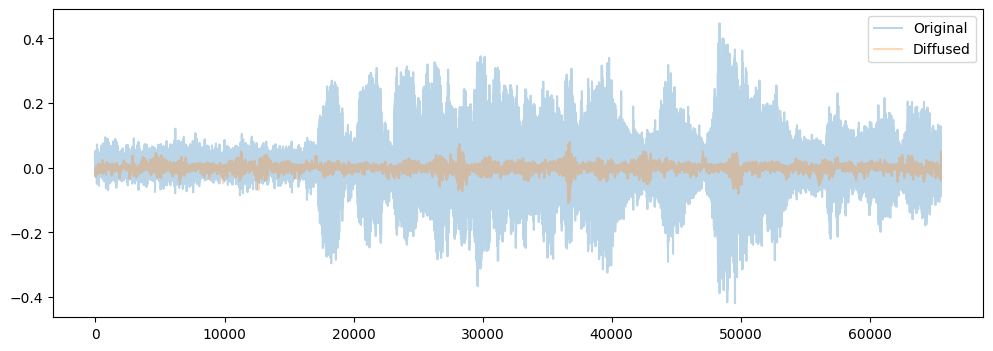

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(real_sample.cpu().numpy(), alpha=0.3, label='Original')
plt.plot(retransformed_pred[0, 0].cpu().numpy(), alpha=0.3, label='Diffused')
plt.legend()

In [7]:
from IPython.display import Audio
Audio(retransformed_pred[0,0], rate=samplerate)


In [8]:
from IPython.display import Audio
Audio(real_sample, rate=samplerate)


In [13]:
import h5py
import matplotlib.pyplot as plt

In [3]:
hdf = h5py.File('../test.hdf5', 'r')